In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

In [2]:
sn.config.seed = 40

# Python RNG - use instead of
# import random
# random.randint(0, 10)
print(sn.config.py_rng.randint(0,10))

# NumPy RNG - use instead of
# import numpy as np
# np.random.randint(0, 10)
print(sn.config.np_rng.integers(0,10))

# TensorFlow RNG - use instead of
# import tensorflow as tf
# tf.random.uniform(shape=[1], minval=0, maxval=10, dtype=tf.int32)
print(sn.config.tf_rng.uniform(shape=[1], minval=0, maxval=10, dtype=tf.int32))

7
5
tf.Tensor([2], shape=(1,), dtype=int32)


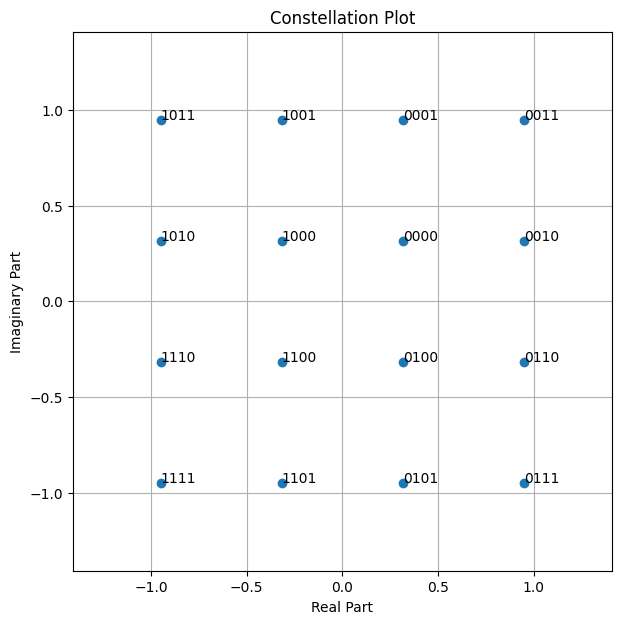

In [20]:
NUM_BITS_PER_SYMBOL = 4 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show();


# Save the plot to a file (e.g., 'qpsk_constellation.png')
#plt.savefig('qam_constellation.png')  # Save as PNG (you can change the file name and format)

# Optionally, you can also close the plot if you don't need to display it.
#plt.close()

Shape of bits:  (64, 1024)
Shape of x:  (64, 512)
Shape of y:  (64, 512)
Shape of llr:  (64, 1024)
First 8 transmitted bits: [0. 0. 1. 1. 1. 0. 0. 1.]
First 4 transmitted symbols: [ 0.71+0.71j -0.71-0.71j -0.71+0.71j  0.71-0.71j]
First 4 received symbols: [ 0.06+1.08j -0.61-1.02j -0.78+2.16j  0.39-1.28j]
First 8 demapped llrs: [-0.27 -4.85  2.73  4.57  3.49 -9.71 -1.74  5.76]


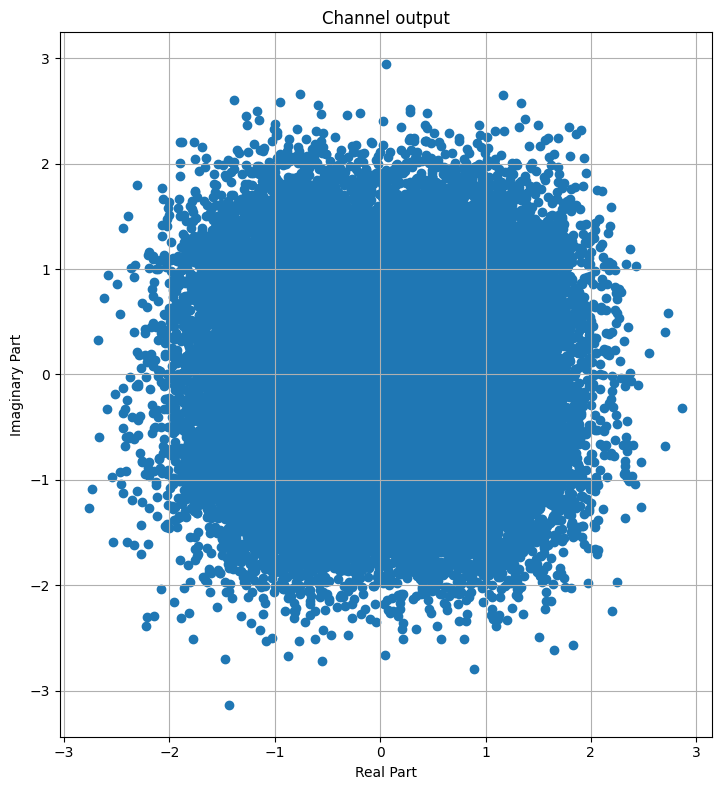

In [11]:
mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)
binary_source = sn.utils.BinarySource()
awgn_channel = sn.channel.AWGN()
no = sn.utils.ebnodb2no(ebno_db=-1.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
print("Shape of bits: ", bits.shape)

x = mapper(bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

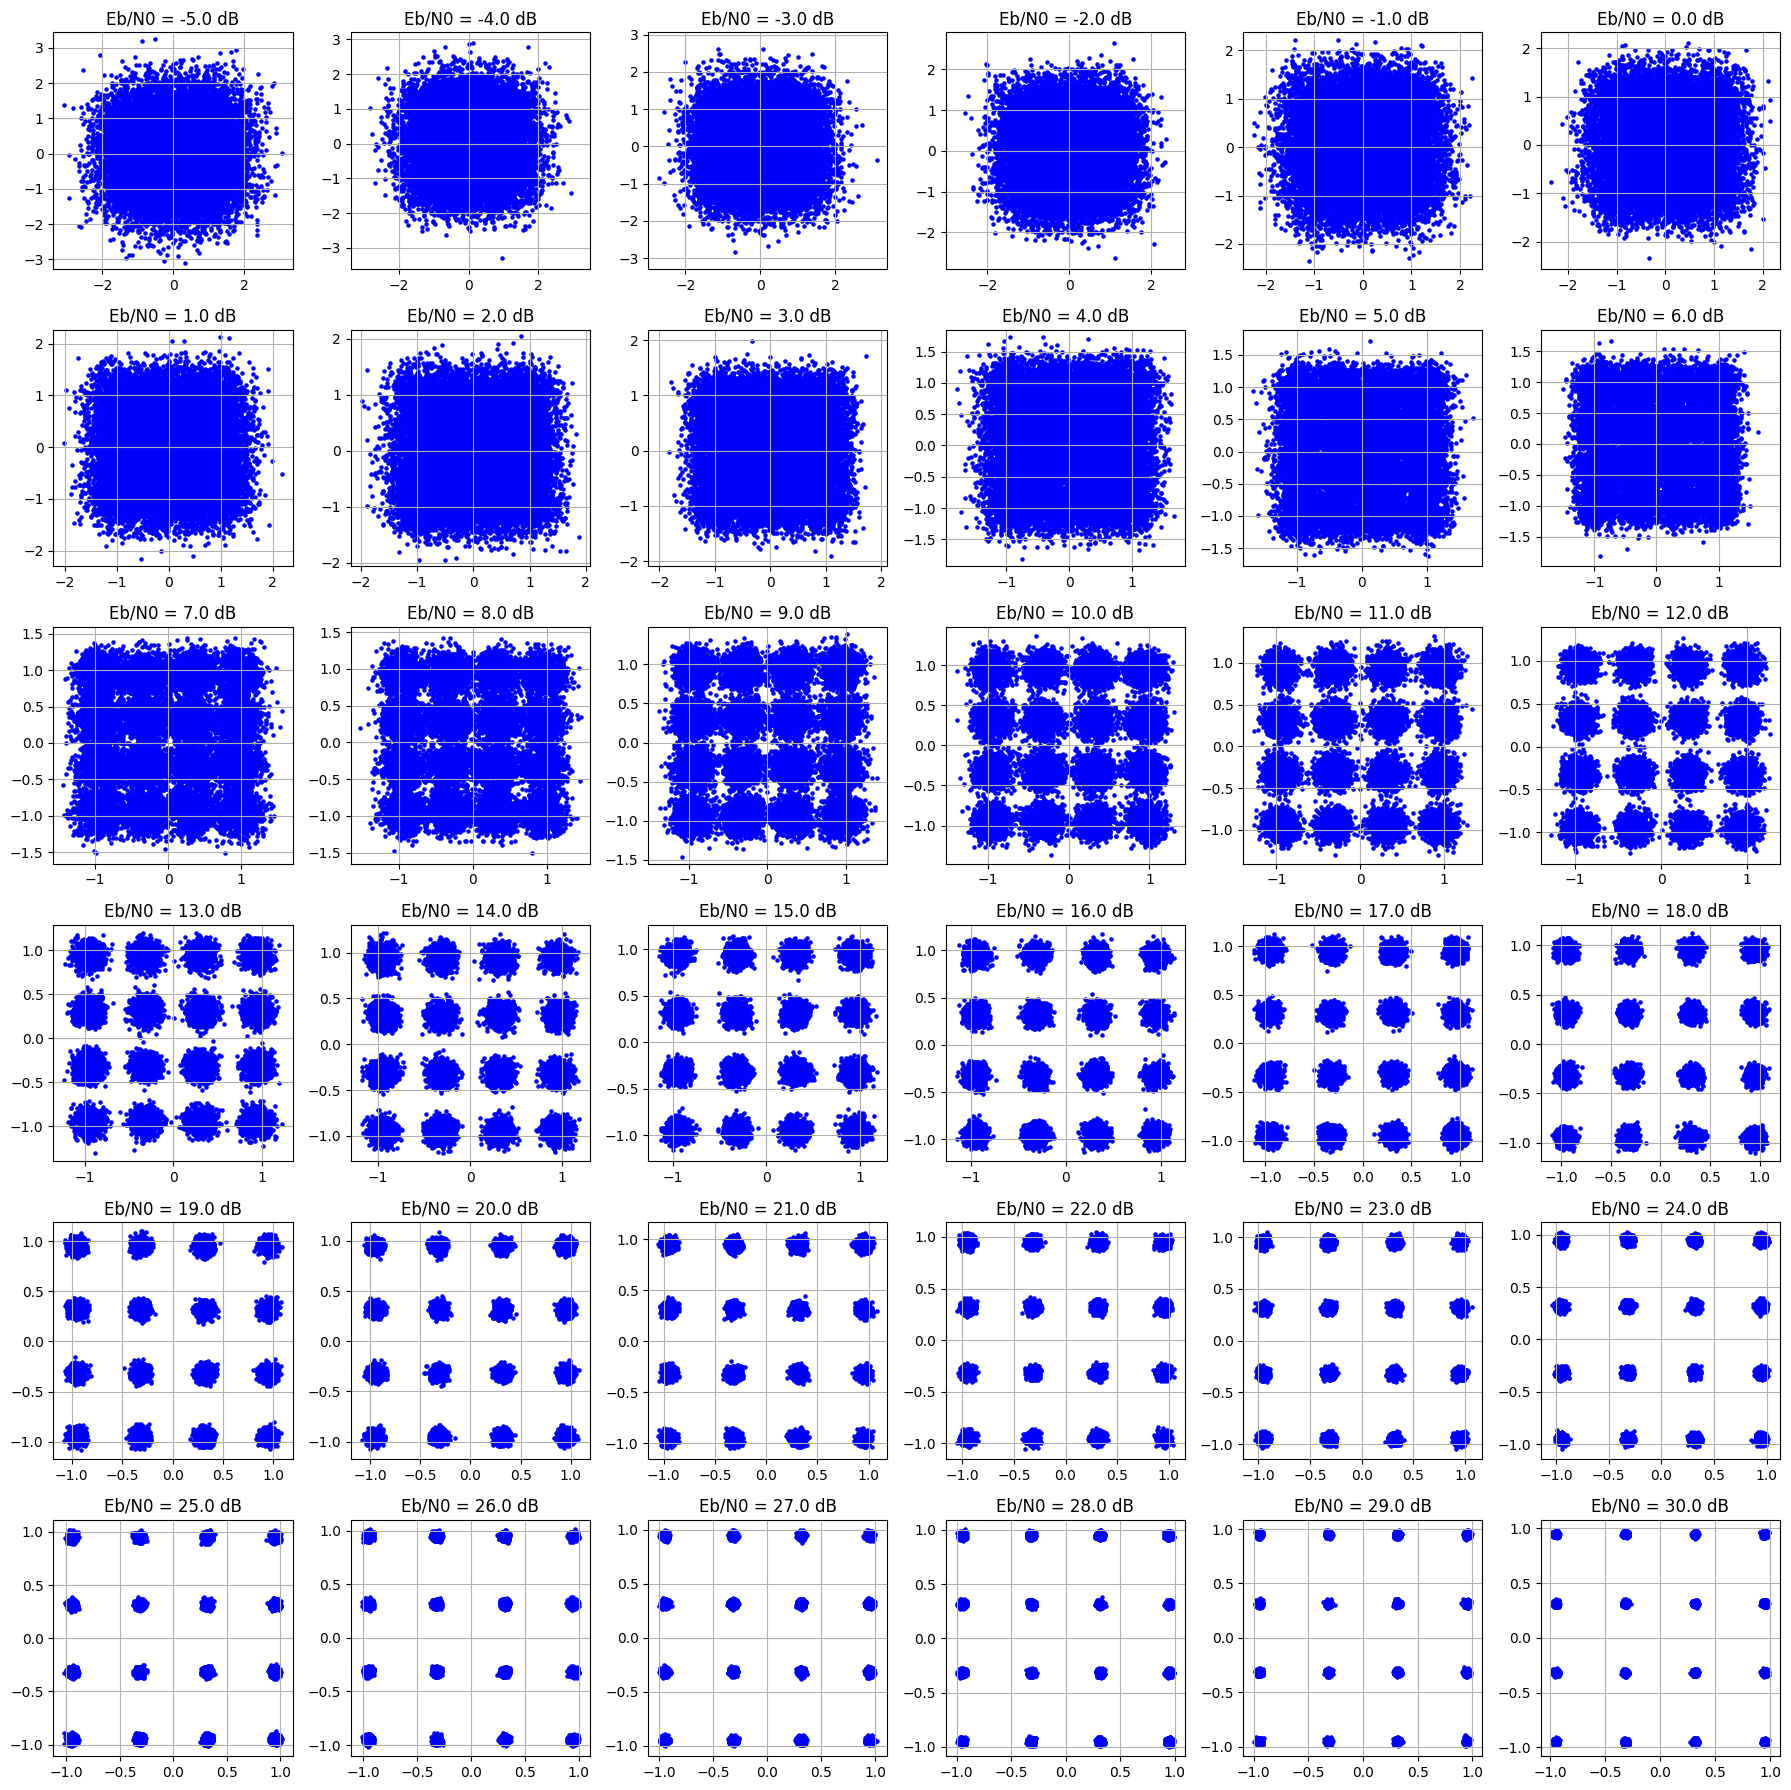

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sionna as sn

# Constants
NUM_BITS_PER_SYMBOL = 4  # For example, 16-QAM (4 bits per symbol)
BATCH_SIZE = 64  # Number of examples processed by Sionna in parallel
num_samples = 8  # How many samples to print
num_symbols = int(num_samples / NUM_BITS_PER_SYMBOL)  # Number of symbols corresponding to num_samples

# Create the constellation object for QAM (16-QAM in this case)
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

# Create the mapper and demapper
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Create the binary source and the AWGN channel
binary_source = sn.utils.BinarySource()
awgn_channel = sn.channel.AWGN()

# Plotting setup
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # 6x6 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to easily index

# Loop through different Eb/N0 values from -5 to 30
ebno_db_values = np.linspace(-5, 30, num=36)  # Create 36 values from -5 to 30 (inclusive)

for i, ebno_db in enumerate(ebno_db_values):
    no = sn.utils.ebnodb2no(ebno_db=ebno_db,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)  # Coderate set to 1 for uncoded transmission
    
    # Generate random bits for transmission
    bits = binary_source([BATCH_SIZE, 1024])  # Blocklength of 1024
    
    # Map the bits to symbols
    x = mapper(bits)
    
    # Transmit the symbols through the AWGN channel
    y = awgn_channel([x, no])
    
    # Demap the received symbols
    llr = demapper([y, no])

    # Plot the constellation of the received symbols (y)
    axes[i].scatter(tf.math.real(y).numpy(), tf.math.imag(y).numpy(), color='blue', s=5)
    axes[i].set_title(f'Eb/N0 = {ebno_db:.1f} dB')
    axes[i].grid(True)
    axes[i].axis('equal')



fig.savefig("awgn_transmit_snr_range.png", dpi=300, bbox_inches='tight')  # Save as PNG
# Tight layout for the subplots
plt.tight_layout()
plt.show()
plt.close(fig)  # Close the figure to prevent display issues


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5901e-01 | 1.0000e+00 |      530445 |     2048000 |         2000 |        2000 |         0.3 |reached target block errors
   -3.158 | 2.1478e-01 | 1.0000e+00 |      439870 |     2048000 |         2000 |        2000 |         0.3 |reached target block errors
   -1.316 | 1.7099e-01 | 1.0000e+00 |      350188 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
    0.526 | 1.2890e-01 | 1.0000e+00 |      263993 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
    2.368 | 8.9725e-02 | 1.0000e+00 |      183757 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
    4.211 | 5.4822e-02 | 1.0000e+00 |      112275 |     2048000 |

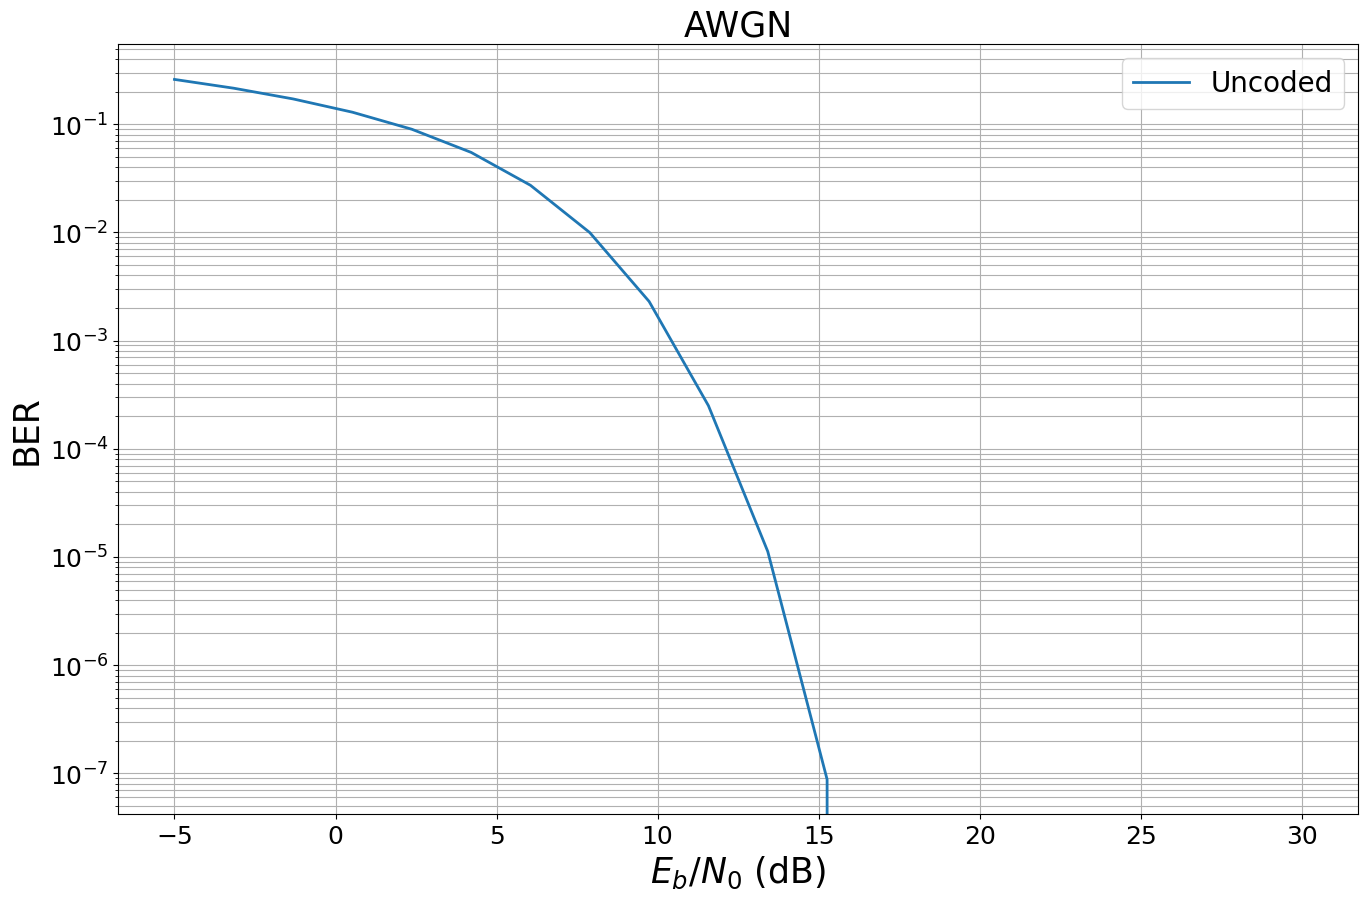

In [17]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, block_length=1024)

EBN0_DB_MIN = -5.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 30.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

plt.savefig('ber_plot_uncoded_awgn.png')  # Save as PNG (you can change the file name and format)

In [32]:
@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.") # print whenever this function is traced
    return model_coded_awgn(batch_size, ebno_db)


class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

EBN0_DB_MIN = -5.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 30.0 # Maximum value of Eb/N0 [dB] for simulations
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=2048,
                                   coderate=CODERATE)

ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

plt.savefig('ber_plot_ldpc_awgn.png')  # Save as PNG (you can change the file name and format)

Tracing run_graph for values batch_size=Tensor("batch_size:0", shape=(), dtype=int32) and ebno_db=Tensor("ebno_db:0", shape=(), dtype=float32).
Note: The value of k cannot be computed before the first call().


ValueError: in user code:

    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/ipykernel_75088/2143216706.py", line 51, in run_graph  *
        return model_coded_awgn(batch_size, ebno_db)
    File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_file79phc7s3.py", line 11, in tf__call
        bits = ag__.converted_call(ag__.ld(self).binary_source, ([ag__.ld(batch_size), ag__.ld(self).encoder.k],), None, fscope)
    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_filejn3x3sih.py", line 13, in tf__call
        retval_ = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(self)._rng.uniform, (ag__.ld(inputs), 0, 2, ag__.ld(tf).int32), None, fscope),), dict(dtype=ag__.converted_call(ag__.ld(super), (), None, fscope).dtype), fscope)

    ValueError: Exception encountered when calling layer 'coded_system_awgn_6' (type CodedSystemAWGN).
    
    in user code:
    
        File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/ipykernel_75088/2143216706.py", line 40, in call  *
            bits = self.binary_source([batch_size, self.encoder.k])  # Generate source bits
        File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_filejn3x3sih.py", line 13, in tf__call
            retval_ = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(self)._rng.uniform, (ag__.ld(inputs), 0, 2, ag__.ld(tf).int32), None, fscope),), dict(dtype=ag__.converted_call(ag__.ld(super), (), None, fscope).dtype), fscope)
    
        ValueError: Exception encountered when calling layer 'binary_source_19' (type BinarySource).
        
        in user code:
        
            File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/sionna/utils/misc.py", line 164, in call  *
                dtype=super().dtype)
        
            ValueError: None values not supported.
        
        
        Call arguments received by layer 'binary_source_19' (type BinarySource):
          • inputs=['tf.Tensor(shape=(), dtype=int32)', 'None']
    
    
    Call arguments received by layer 'coded_system_awgn_6' (type CodedSystemAWGN):
      • batch_size=tf.Tensor(shape=(), dtype=int32)
      • ebno_db=tf.Tensor(shape=(), dtype=float32)


In [33]:
import numpy as np
import sionna as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model

# Define Convolutional Encoder and Decoder System
class CodedSystemAWGN(Model):  # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, coderate):
        super().__init__()  # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.coderate = coderate
        
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()
        
        # Convolutional Encoder with constraint length 7 and rate 1/2
        self.encoder = sn.fec.conv.ConvEncoder(
            gen_poly=('1111001', '1011011'),  # Generator polynomials in binary
            rate=1/2,  # Code rate
            constraint_length=7  # Constraint length
        )
        
        # Convolutional Decoder using Viterbi Algorithm
        self.decoder = sn.fec.conv.ViterbiDecoder(
            gen_poly=('1111001', '1011011'),  # Generator polynomials in binary
            rate=1/2,  # Code rate
            constraint_length=7,  # Constraint length
            method='soft_llr',  # Use soft input LLRs
            output_dtype=tf.float32  # Output data type
        )

    def call(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.encoder.k])  # Generate source bits
        codewords = self.encoder(bits)  # Convolutionally encode the bits
        x = self.mapper(codewords)  # Map the codewords to symbols
        y = self.awgn_channel([x, no])  # Transmit over the AWGN channel
        llr = self.demapper([y, no])  # Demap the received symbols
        bits_hat = self.decoder(llr)  # Decode the received symbols with Viterbi decoder
        return bits, bits_hat

@tf.function()  # Enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.")  # Print whenever traced
    return model_coded_awgn(batch_size, ebno_db)

# Simulation parameters
EBN0_DB_MIN = -5.0  # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0  # Reduced max value to focus on relevant SNR range
CODERATE = 0.5
BATCH_SIZE = 2000

# Create the model with convolutional coding
model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=2, coderate=CODERATE)

# BER Plot object
ber_plots = sn.utils.PlotBER("AWGN")

# Run the simulation
ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,  # Run 100 Monte-Carlo simulations
                   show_fig=True,
                   forward_keyboard_interrupt=False)

# Save the plot to a file
plt.savefig('ber_plot_conv_awgn.png')

Tracing run_graph for values batch_size=Tensor("batch_size:0", shape=(), dtype=int32) and ebno_db=Tensor("ebno_db:0", shape=(), dtype=float32).
Note: The value of k cannot be computed before the first call().


ValueError: in user code:

    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/ipykernel_75088/2143216706.py", line 51, in run_graph  *
        return model_coded_awgn(batch_size, ebno_db)
    File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_file79phc7s3.py", line 11, in tf__call
        bits = ag__.converted_call(ag__.ld(self).binary_source, ([ag__.ld(batch_size), ag__.ld(self).encoder.k],), None, fscope)
    File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_filejn3x3sih.py", line 13, in tf__call
        retval_ = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(self)._rng.uniform, (ag__.ld(inputs), 0, 2, ag__.ld(tf).int32), None, fscope),), dict(dtype=ag__.converted_call(ag__.ld(super), (), None, fscope).dtype), fscope)

    ValueError: Exception encountered when calling layer 'coded_system_awgn_7' (type CodedSystemAWGN).
    
    in user code:
    
        File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/ipykernel_75088/2143216706.py", line 40, in call  *
            bits = self.binary_source([batch_size, self.encoder.k])  # Generate source bits
        File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/4s/b7gb8z5553b490xvx_76pv6m0000gn/T/__autograph_generated_filejn3x3sih.py", line 13, in tf__call
            retval_ = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(self)._rng.uniform, (ag__.ld(inputs), 0, 2, ag__.ld(tf).int32), None, fscope),), dict(dtype=ag__.converted_call(ag__.ld(super), (), None, fscope).dtype), fscope)
    
        ValueError: Exception encountered when calling layer 'binary_source_20' (type BinarySource).
        
        in user code:
        
            File "/Users/athmajanvivekananthan/miniforge3/envs/sionna_env_conda_3_10/lib/python3.10/site-packages/sionna/utils/misc.py", line 164, in call  *
                dtype=super().dtype)
        
            ValueError: None values not supported.
        
        
        Call arguments received by layer 'binary_source_20' (type BinarySource):
          • inputs=['tf.Tensor(shape=(), dtype=int32)', 'None']
    
    
    Call arguments received by layer 'coded_system_awgn_7' (type CodedSystemAWGN):
      • batch_size=tf.Tensor(shape=(), dtype=int32)
      • ebno_db=tf.Tensor(shape=(), dtype=float32)
